# This script demonstrates how to train a M²VAE with a split MNIST data set

In [16]:
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.1
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


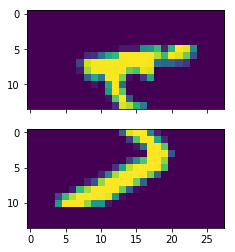

In [17]:
# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
batch_size = 1024
original_dim = img_rows * img_cols * img_chns
split_dim = int(original_dim / 2)

# Split it horizontally
x_train_a = x_train[:,:split_dim]
x_train_b = x_train[:,split_dim:]
x_test_a = x_test[:,:split_dim]
x_test_b = x_test[:,split_dim:]

# Show a split image

f, ax = plt.subplots(2,1,sharex=True)
ax[0].imshow(x_train_a[0,:].reshape(((int(img_rows/2), img_cols))))
ax[1].imshow(x_train_b[0,:].reshape(((int(img_rows/2), img_cols))))
plt.show()

Store model to filename: tmp/myVAE.png and tmp/myVAE.svg
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            [(None, 392)]        0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            [(None, 392)]        0                                            
__________________________________________________________________________________________________
enc_0_a (Dense)                 (None, 256)          100608      input_a[0][0]                    
                                                                 input_a[0][0]                    
__________________________________________________________________________________________________
enc_0_b (Dense)                 (No

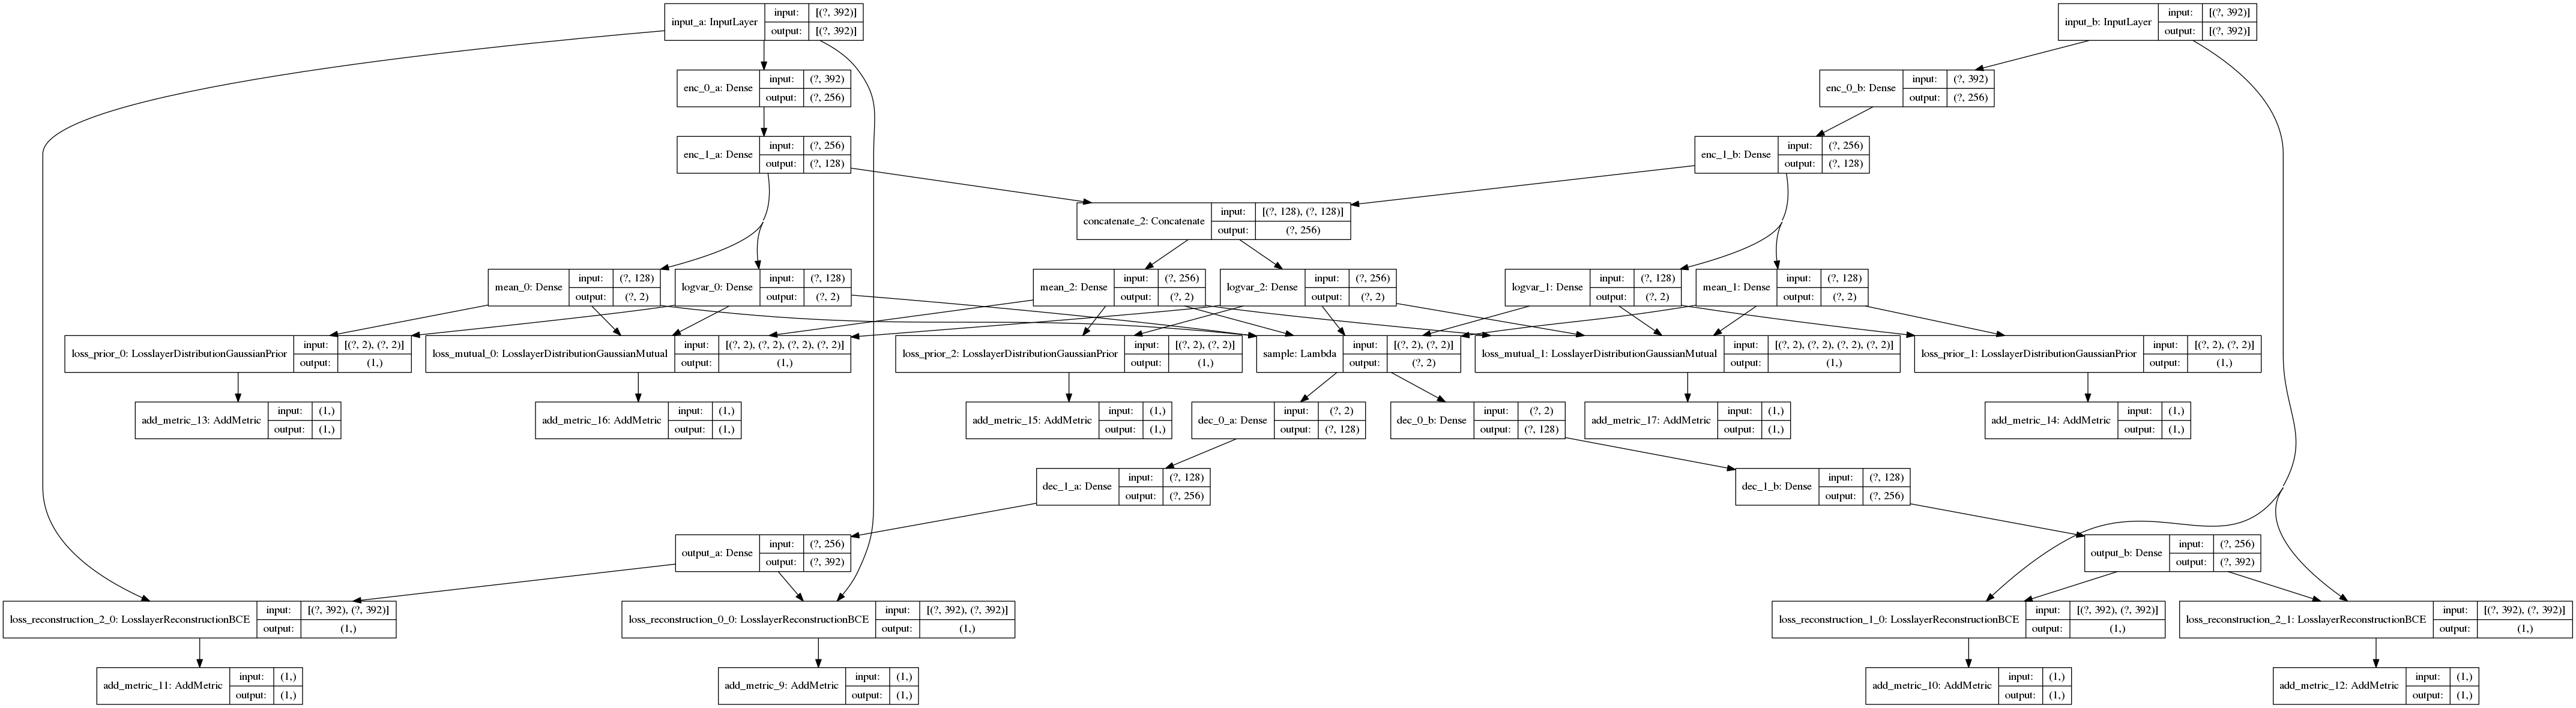

In [18]:
# network configuration
batch_size = 1024
intermediate_dim = 256
epochs = 60
z_dim = 2
beta = 1.

encoder = [
    [
        Input(shape=(split_dim,), name="input_a"),
        Dense(intermediate_dim, activation='relu', name="enc_0_a"),
        Dense(int(intermediate_dim/2), activation='relu', name="enc_1_a")
    ],
    [
        Input(shape=(split_dim,), name="input_b"),
        Dense(intermediate_dim, activation='relu', name="enc_0_b"),
        Dense(int(intermediate_dim/2), activation='relu', name="enc_1_b")
    ],
]

decoder = [
    [
        Dense(int(intermediate_dim/2), activation='relu', name="dec_0_a"),
        Dense(intermediate_dim, activation='relu', name="dec_1_a"),
        Dense(split_dim, activation='sigmoid', name="output_a")
    ],
    [
        Dense(int(intermediate_dim/2), activation='relu', name="dec_0_b"),
        Dense(intermediate_dim, activation='relu', name="dec_1_b"),
        Dense(split_dim, activation='sigmoid', name="output_b")
    ]
]

vae_obj = MmVae(z_dim, encoder, decoder, [split_dim, split_dim], beta, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='MMVAE')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [19]:
# Store the losses, encodings, and decodings to tensorboard
# It is important to include the native Tensorboard callback as well besides vae_tools.callbacks.Tb*
log_dir = './Graph/mnist_wo_conv'

writer = tf.summary.create_file_writer(log_dir) # Get a writer for our own callbacks
np.savetxt(log_dir + "y_test.tsv", y_test, fmt="%d", delimiter="\t") # Store the labels for the embedding
# TODO fix behaviour of embeddings_metadata="y_test.tsv" in tensorflow 2.0
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True, embeddings_freq=1, update_freq='epoch')
tbembedding_cb = vae_tools.callbacks.TbEmbedding(writer = writer, data = x_test, encoder_model = vae_obj.get_encoder_mean([encoder[0][0]]), labels = y_test, log_dir=log_dir)
tbdecoding_cb = vae_tools.callbacks.TbDecoding2dGaussian(writer = writer, decoder_model = vae_obj.get_decoder(), log_dir=log_dir)
# Train
h = vae.fit([x_train_a, x_train_b],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test_a, x_test_b], None),
            verbose = 1
            #callbacks=[tb_cb, tbdecoding_cb, tbembedding_cb]
            )

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 11s 179us/sample - loss: 515.4013 - loss_reconstruction_0_0_2: 121.4095 - loss_reconstruction_1_0_2: 131.5847 - loss_reconstruction_2_0_2: 117.7161 - loss_reconstruction_2_1_2: 128.3536 - loss_prior_0_2: 2.9987 - loss_prior_1_2: 2.9197 - loss_prior_2_2: 6.6806 - loss_mutual_0_2: 1.6840 - loss_mutual_1_2: 1.3732 - val_loss: 413.4118 - val_loss_reconstruction_0_0_2: 98.4696 - val_loss_reconstruction_1_0_2: 107.4259 - val_loss_reconstruction_2_0_2: 95.1814 - val_loss_reconstruction_2_1_2: 104.5468 - val_loss_prior_0_2: 0.9866 - val_loss_prior_1_2: 1.2536 - val_loss_prior_2_2: 3.2574 - val_loss_mutual_0_2: 1.2798 - val_loss_mutual_1_2: 0.9976

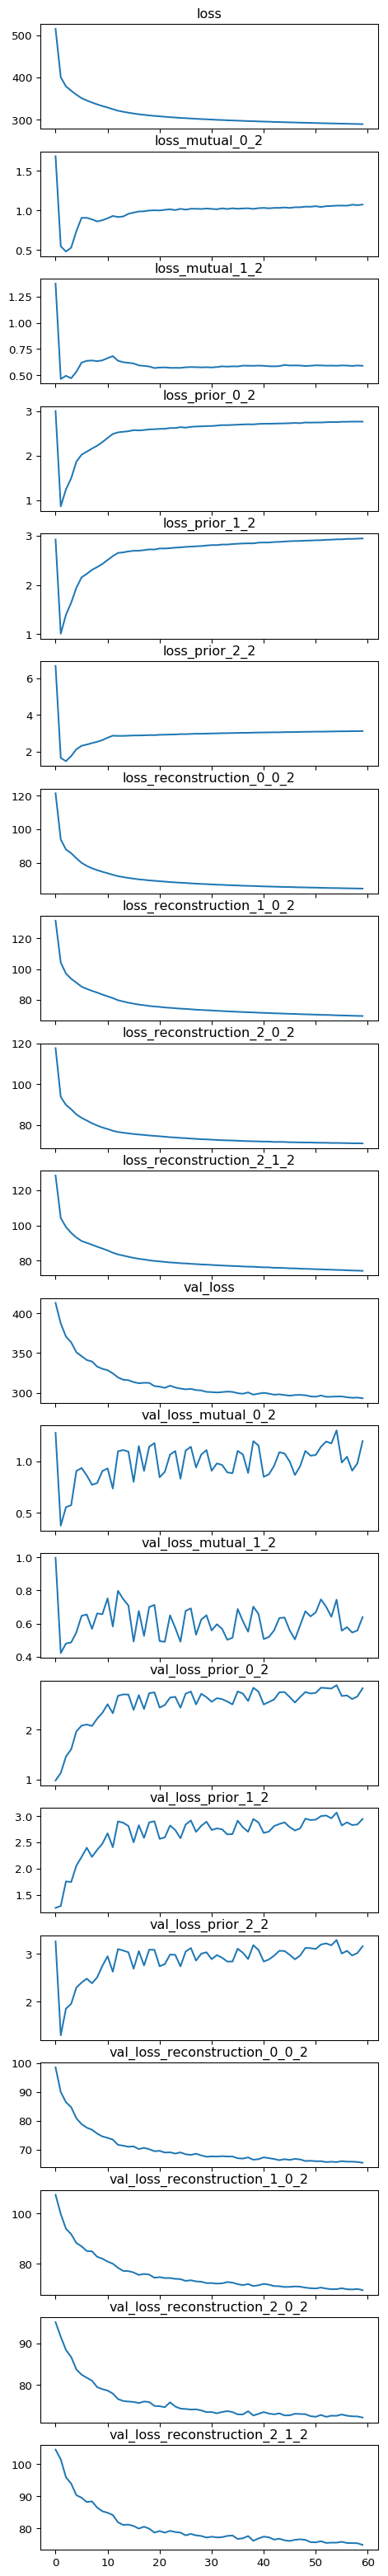

In [20]:
# Show the losses (loss is ELBO)
vae_tools.viz.plot_losses(h, dpi=96, figsize_height_factor = .325)
plt.show()

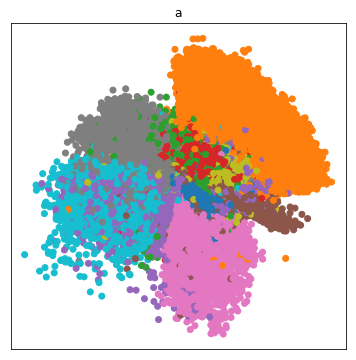

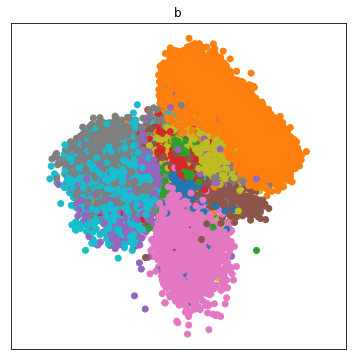

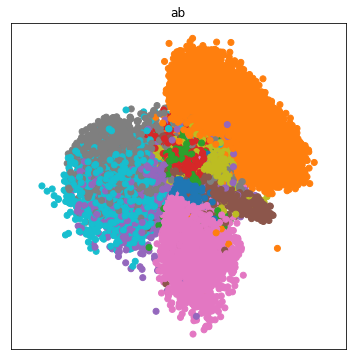

In [23]:
# Get the models
encoder_input = [encoder[0][0], encoder[1][0]]
encoder_mean = [vae_obj.get_encoder_mean([encoder_input[0]]),
                             vae_obj.get_encoder_mean([encoder_input[1]]),
                             vae_obj.get_encoder_mean(encoder_input)]
encoder_logvar = [vae_obj.get_encoder_logvar([encoder_input[0]]),
                               vae_obj.get_encoder_logvar([encoder_input[1]]),
                               vae_obj.get_encoder_logvar(encoder_input)]

mean_encoded_a = encoder_mean[0].predict(x_train_a)
mean_encoded_b = encoder_mean[1].predict(x_train_b)
mean_encoded_ab = encoder_mean[2].predict([x_train_a, x_train_b])
vae_tools.viz.plot_embedding(mean_encoded_a, y_train, colormap='tab10', figsize=(6, 6))
plt.axis("equal")
plt.title("a")
plt.show()

vae_tools.viz.plot_embedding(mean_encoded_b, y_train, colormap='tab10', figsize=(6, 6))
plt.axis("equal")
plt.title("b")
plt.show()

vae_tools.viz.plot_embedding(mean_encoded_ab, y_train, colormap='tab10', figsize=(6, 6))
plt.axis("equal")
plt.title("ab")
plt.show()

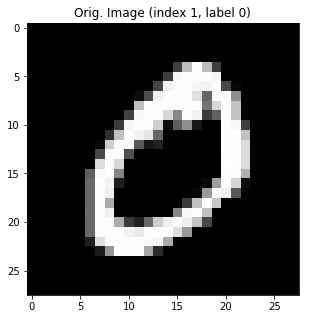

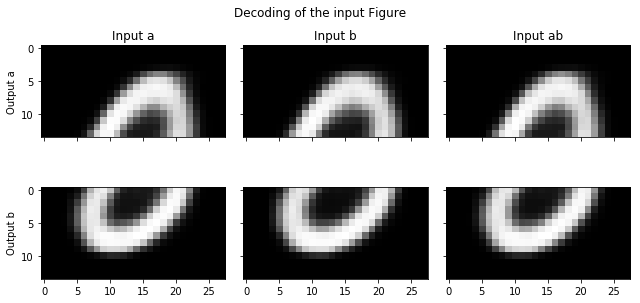

In [67]:
idx = 1
_, ax = plt.subplots(1,1,True,True,figsize=(5, 5))
ax.imshow(x_train[idx].reshape((img_rows, img_cols)), cmap='Greys_r')
ax.set_title("Orig. Image (index %d, label %d)" %(idx, y_train[idx]))
plt.show()

# Input image:
mean_encoded_a = encoder_mean[0].predict(x_train_a[[idx]])
mean_encoded_b = encoder_mean[1].predict(x_train_b[[idx]])
mean_encoded_ab = encoder_mean[2].predict([x_train_a[[idx]], x_train_b[[idx]]])

# build a digit generator that can sample from the learned distribution
generator = vae_obj.get_decoder()
decoded_a = generator.predict(mean_encoded_a)
decoded_b = generator.predict(mean_encoded_b)
decoded_ab = generator.predict(mean_encoded_ab)

f, ax = plt.subplots(2,3,True,True,figsize=(9, 4.5))
ax[0,0].imshow(decoded_a[0].reshape((int(img_rows/2), img_cols)), cmap='Greys_r')
ax[1,0].imshow(decoded_a[1].reshape((int(img_rows/2), img_cols)), cmap='Greys_r')
ax[0,1].imshow(decoded_b[0].reshape((int(img_rows/2), img_cols)), cmap='Greys_r')
ax[1,1].imshow(decoded_b[1].reshape((int(img_rows/2), img_cols)), cmap='Greys_r')
ax[0,2].imshow(decoded_ab[0].reshape((int(img_rows/2), img_cols)), cmap='Greys_r')
ax[1,2].imshow(decoded_ab[1].reshape((int(img_rows/2), img_cols)), cmap='Greys_r')
ax[0,0].set_title('Input a')
ax[0,1].set_title('Input b')
ax[0,2].set_title('Input ab')
ax[0,0].set_ylabel('Output a')
ax[1,0].set_ylabel('Output b')
f.suptitle('Decoding of the input Figure')
plt.tight_layout()
plt.show()
